In [1]:
# %matplotlib inline
# %matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

import cv2


import torch
from torch import nn
from torchvision import datasets
import torchvision.datasets.utils as dataset_utils

import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchmetrics import Accuracy, AUROC
import time
import torch.nn.functional as F

from PIL import Image

import pickle as pkl

import time

from sklearn.model_selection import StratifiedShuffleSplit
SEED = 1234

In [2]:
def image_histogram_equalization(image, number_bins=256):
    # from http://www.janeriksolem.net/histogram-equalization-with-python-and.html
    # https://en.wikipedia.org/wiki/Histogram_equalization
    # https://stackoverflow.com/a/28520445
    
    # get image histogram
    image_histogram, bins = np.histogram(image.flatten(), number_bins, density=True)
    cdf = image_histogram.cumsum() # cumulative distribution function
    cdf = (number_bins-1) * cdf / cdf[-1] # normalize

    # use linear interpolation of cdf to find new pixel values
    image_equalized = np.interp(image.flatten(), bins[:-1], cdf)

    return image_equalized.reshape(image.shape), cdf


In [3]:

t0 = time.time()


dataDir='coco'
dataType='train2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)

# initialize COCO api for instance annotations
coco_train=COCO(annFile)

# dataDir='coco'
# dataType='val2017'
# annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)

# coco_val = COCO(annFile)

# display COCO categories and supercategories
cats = coco_train.loadCats(coco_train.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

animal_id_dict = {}

animal_category_ids = coco_train.getCatIds(supNms=['animal'])
vehicle_category_ids = coco_train.getCatIds(supNms=['vehicle'])

animal_id_dict['animal'] = []
animal_id_dict['vehicle'] = []

for cat_id in animal_category_ids:
    animal_id_dict['animal'].extend(coco_train.getImgIds(catIds=cat_id))
#    print(len(animal_id_dict[cat_id]))

for cat_id in vehicle_category_ids:
    animal_id_dict['vehicle'].extend(coco_train.getImgIds(catIds=cat_id))
#    print(len(animal_id_dict[cat_id]))

# animal_id_dict_val = {}
# print('\n')
# for cat_id in animal_category_ids:
#     animal_id_dict_val[cat_id] = coco_val.getImgIds(catIds=cat_id)
#     print(len(animal_id_dict_val[cat_id]))


animal_intersections = {}
for key, value in animal_id_dict.items():
    animal_intersections[key] = []
    for key_2, value_2 in animal_id_dict.items():
        if key != key_2:
            animal_intersections[key].extend(x for x in list(set(value).intersection(value_2)) if x not in animal_intersections[key])

# animal_intersections_val = {}
# for key, value in animal_id_dict_val.items():
#     animal_intersections_val[key] = []
#     for key_2, value_2 in animal_id_dict_val.items():
#         if key != key_2:
#             animal_intersections_val[key].extend(x for x in list(set(value).intersection(value_2)) if x not in animal_intersections_val[key])

animal_no_intersections = {}
sum = 0
for key, value in animal_intersections.items():
    animal_no_intersections[key] = [x for x in animal_id_dict[key] if x not in value]
    print(key, len(animal_id_dict[key]), len(value), len(animal_no_intersections[key]))
    sum += len(animal_no_intersections[key])

# animal_no_intersections_val = {}
# sum_val = 0
# for key, value in animal_intersections_val.items():
#     animal_no_intersections_val[key] = [x for x in animal_id_dict_val[key] if x not in value]
#     print(key, len(animal_id_dict_val[key]), len(value), len(animal_no_intersections_val[key]))
#     sum_val += len(animal_no_intersections_val[key])

loading annotations into memory...
Done (t=19.55s)
creating index...
index created!
COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

COCO supercategories: 
sports vehicle kitchen electronic food animal appliance outdoor furniture accessory person indoor
animal 25739 3013 22554
vehicle 38683 3013 34734


In [23]:

n = 20
n_per_class = 10

im_size = 224

data = np.zeros((n, im_size,im_size,3))
labels = np.zeros((n,))
masks = np.zeros((n, im_size,im_size))

control_bounds = [0.2,0.8]

j = 0

from skimage.exposure import match_histograms
import scipy.stats
import seaborn as sns



mu = 0.5
sigma = 0.2
N = 224*224

lower = 0.2
upper = 0.8

def sort_ref(ref):
    ref_norm = ref.copy()
    return ref_norm[np.argsort(ref)]

ref_01 = sort_ref(scipy.stats.truncnorm.rvs((0.0-mu)/sigma,(1.0-mu)/sigma,loc=mu,scale=sigma,size=N))    
ref_19 = sort_ref(scipy.stats.truncnorm.rvs((0.1-mu)/sigma,(0.9-mu)/sigma,loc=mu,scale=sigma,size=N))
ref_28 = sort_ref(scipy.stats.truncnorm.rvs((lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma,size=N)) # Control
ref_37 = sort_ref(scipy.stats.truncnorm.rvs((0.3-mu)/sigma,(0.7-mu)/sigma,loc=mu,scale=sigma,size=N))
ref_46 = sort_ref(scipy.stats.truncnorm.rvs((0.4-mu)/sigma,(0.6-mu)/sigma,loc=mu,scale=sigma,size=N)) 



datasets = {
    'norm': {
        'ref': ref_28.copy(),
        'data': np.zeros((n, im_size,im_size,3))
    },
    'conf_1': {
        'ref_0': ref_19.copy(),
        'ref_1': ref_37.copy(),
        'data': np.zeros((n, im_size,im_size,3))
    },
    'conf_2': {
        'ref_0': ref_01.copy(),
        'ref_1': ref_46.copy(),
        'data': np.zeros((n, im_size,im_size,3))
    },
    'sup_1': {
        'ref_0': ref_19.copy(),
        'ref_1': ref_37.copy(),
        'data': np.zeros((n, im_size,im_size,3))
    },
    'sup_2': {
        'ref_0': ref_01.copy(),
        'ref_1': ref_46.copy(),
        'data': np.zeros((n, im_size,im_size,3))
    },
}


for i, (key, value) in enumerate(animal_no_intersections.items()):
    if len(value) >= n_per_class:
        print(i, key, len(value))

        for id in value[:n_per_class]:
            img = coco_train.loadImgs(id)[0]
    
            I = cv2.resize(cv2.imread(f'./coco/train2017/{img["file_name"]}', cv2.IMREAD_COLOR), (im_size,im_size))

            out_norm = np.asarray(cv2.cvtColor(   I, cv2.COLOR_RGB2HLS ))  # a bitmap conversion 
            # out_norm[:,:,1] = image_histogram_equalization(out_norm[:,:,1])[0]
            out_norm = out_norm / 255

            for dataset, value in datasets.items():
                copied = out_norm.copy()
                lightness_flattened = copied[:,:,1].reshape((im_size*im_size,))
                if dataset == 'norm':
                    lightness_flattened[np.argsort(lightness_flattened)] = value['ref']
                elif 'conf' in dataset:
                    lightness_flattened[np.argsort(lightness_flattened)] = value[f'ref_{i}']
                else:
                    if j >= int(n_per_class/2):
                        lightness_flattened[np.argsort(lightness_flattened)] = value[f'ref_1']
                    else:
                        lightness_flattened[np.argsort(lightness_flattened)] = value[f'ref_0']
                copied[:,:,1] = lightness_flattened.reshape((im_size,im_size))
                value['data'][j] = copied
            
            
            # sorted_norm = data_not_norm[data_ind][:,:,1].copy().reshape((224*224,))

            # ref_norm = ref_28.copy()
            # ref_sorted = ref_sorted[np.argsort(ref)]
            
            # sorted[np.argsort(sorted)] = ref_sorted
        
            # copied = data_not_norm[data_ind].copy()
            # copied[:,:,1] = sorted.reshape((224,224))
            
            annotation_ids = coco_train.getAnnIds(imgIds=id, catIds=[], iscrowd=False)
            annotations = coco_train.loadAnns(annotation_ids)
            
            mask = np.zeros(coco_train.annToMask(annotations[0]).shape)
            for annotation in annotations:
                # print(annotation)
                if key == 'animal':
                    if annotation['category_id'] in animal_category_ids:
                        masks_animal = coco_train.annToMask(annotation)
                        # print(masks)
                        mask += masks_animal
                elif key == 'vehicle':
                    if annotation['category_id'] in vehicle_category_ids:
                        masks_animal = coco_train.annToMask(annotation)
                        mask += masks_animal
            mask[mask!=0] = 1

            mask_im = Image.fromarray(np.uint8(mask)).convert('RGB').resize((im_size,im_size))
            
            # data[j] = out_norm
            labels[j] = i
            masks[j] = np.asarray(mask_im)[:,:,0]
            
            j+=1

0 animal 22554
1 vehicle 34734


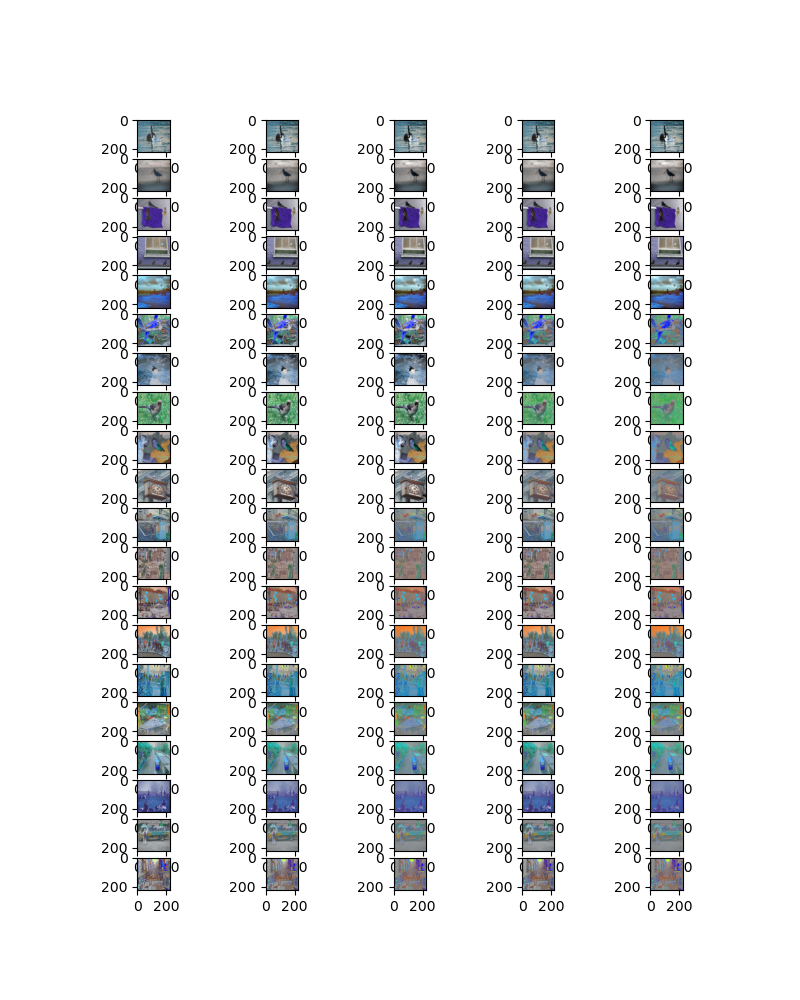

In [26]:
%matplotlib ipympl
fig, axs = plt.subplots(20,5)

for i, (dataset, value) in enumerate(datasets.items()):
    for j in range(20):
        # axs[j,i].imshow(value['data'][j])
        axs[j,i].imshow(cv2.cvtColor( (value['data'][j]*255).astype(np.uint8)  , cv2.COLOR_HLS2RGB ))

In [5]:
def create_conf_data(data, n=20000, n_per_class=10000):
    conf_data = data.copy()

    # animals = brightness * 0.8
    # vehicles = brightness * 0.5
    # should I use the same brightness for all images of the given class?
    # or should I do a 50% normalised 50% not normalised split?

    return conf_data

def create_sup_data(data, n=20000, n_per_class=10000):
    sup_data = data.copy()

    # random brightness - should I pick ~5 fixed brightness levels and evenly distribute, or should I use a continuous distribution?

    return sup_data


In [6]:
data_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=SEED)
train_indices, val_indices = list(data_splitter.split(X=data, y=labels))[0]


x_train = data[train_indices]
y_train = labels[train_indices]
x_val_test = data[val_indices]
y_val_test = labels[val_indices]

data_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=SEED)
val_indices, test_indices = list(data_splitter.split(X=x_val_test, y=y_val_test))[0]

x_val = x_val_test[val_indices]
y_val = y_val_test[val_indices]

x_test = x_val_test[test_indices]
y_test = y_val_test[test_indices]


split_dataset_norm = [(x_train, y_train, masks[train_indices]), (x_val, y_val, masks[val_indices]), (x_test, y_test, masks[test_indices])]

with open('coco_data_norm.pkl', 'wb') as f:
    pkl.dump(split_dataset_norm, f)


print('time to pre-process and save coco datasets:', time.time() - t0)


time to pre-process and save coco datasets: 47.151206493377686
